In [ ]:
from google.colab import drive

import numpy as np

import pandas as pd

from scipy.stats import chi2_contingency, randint, uniform, ttest_ind
from scipy.stats.contingency import association

import seaborn as sns

import shap

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
  classification_report,
  PrecisionRecallDisplay,
  RocCurveDisplay,
)
from sklearn.model_selection import (
  cross_val_score,
  train_test_split,
  RandomizedSearchCV,
)
from sklearn.preprocessing import (
  LabelEncoder,
  MinMaxScaler,
  OneHotEncoder,
  OrdinalEncoder,
)

import xgboost as xgb

In [ ]:
HEX_BLUE = '#48a8c4'
HEX_RED = '#c0504d'

# Prepare data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dibimbing Bootcamp Data Science/bank_churn_data.csv')
df.shape

(10127, 21)

In [ ]:
df.sample(3)

user_id     attrition_flag  customer_age gender  dependent_count  \
7347  770800683  Existing Customer            48      F                3   
4213  789520533  Existing Customer            52      M                2   
4218  747107508  Existing Customer            56      F                3   

     education_level marital_status income_category card_category  \
7347   Post-Graduate        Married  Less than $40K          Blue   
4213      Uneducated         Single         $120K +          Blue   
4218        Graduate         Single  Less than $40K          Blue   

      months_on_book  ...  months_inactive_12_mon  contacts_count_12_mon  \
7347              35  ...                       3                      3   
4213              44  ...                       3                      2   
4218              49  ...                       3                      1   

      credit_limit  total_revolving_bal  avg_open_to_buy  \
7347        2640.0                 2133            507.0   
4213       26174.0                 1864          24310.0   
4218        2433.0                 1947            486.0   

      total_amt_chng_q4_q1  total_trans_amt  total_trans_ct  \
7347                 1.008             4956              72   
4213                 0.684             4551              65   
4218                 0.816             4269              88   

      total_ct_chng_q4_q1  avg_utilization_ratio  
7347                0.846                  0.808  
4213                0.667                  0.071  
4218                0.760                  0.800  

[3 rows x 21 columns]

## Check data types and missing values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

In [ ]:
df.describe()

user_id  customer_age  dependent_count  months_on_book  \
count  1.012700e+04  10127.000000     10127.000000    10127.000000   
mean   7.391776e+08     46.325960         2.346203       35.928409   
std    3.690378e+07      8.016814         1.298908        7.986416   
min    7.080821e+08     26.000000         0.000000       13.000000   
25%    7.130368e+08     41.000000         1.000000       31.000000   
50%    7.179264e+08     46.000000         2.000000       36.000000   
75%    7.731435e+08     52.000000         3.000000       40.000000   
max    8.283431e+08     73.000000         5.000000       56.000000   

       total_relationship_count  months_inactive_12_mon  \
count              10127.000000            10127.000000   
mean                   3.812580                2.341167   
std                    1.554408                1.010622   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       contacts_count_12_mon  credit_limit  total_revolving_bal  \
count           10127.000000  10127.000000         10127.000000   
mean                2.455317   8631.953698          1162.814061   
std                 1.106225   9088.776650           814.987335   
min                 0.000000   1438.300000             0.000000   
25%                 2.000000   2555.000000           359.000000   
50%                 2.000000   4549.000000          1276.000000   
75%                 3.000000  11067.500000          1784.000000   
max                 6.000000  34516.000000          2517.000000   

       avg_open_to_buy  total_amt_chng_q4_q1  total_trans_amt  total_trans_ct  \
count     10127.000000          10127.000000     10127.000000    10127.000000   
mean       7469.139637              0.759941      4404.086304       64.858695   
std        9090.685324              0.219207      3397.129254       23.472570   
min           3.000000              0.000000       510.000000       10.000000   
25%        1324.500000              0.631000      2155.500000       45.000000   
50%        3474.000000              0.736000      3899.000000       67.000000   
75%        9859.000000              0.859000      4741.000000       81.000000   
max       34516.000000              3.397000     18484.000000      139.000000   

       total_ct_chng_q4_q1  avg_utilization_ratio  
count         10127.000000           10127.000000  
mean              0.712222               0.274894  
std               0.238086               0.275691  
min               0.000000               0.000000  
25%               0.582000               0.023000  
50%               0.702000               0.176000  
75%               0.818000               0.503000  
max               3.714000               0.999000

In [ ]:
df.isnull().sum()

user_id                     0
attrition_flag              0
customer_age                0
gender                      0
dependent_count             0
education_level             0
marital_status              0
income_category             0
card_category               0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
contacts_count_12_mon       0
credit_limit                0
total_revolving_bal         0
avg_open_to_buy             0
total_amt_chng_q4_q1        0
total_trans_amt             0
total_trans_ct              0
total_ct_chng_q4_q1         0
avg_utilization_ratio       0
dtype: int64

In [ ]:
df['attrition_flag'].value_counts(normalize=True)

attrition_flag
Existing Customer    0.83934
Attrited Customer    0.16066
Name: proportion, dtype: float64

In [ ]:
# Buat label target
df['churn_flag'] = df['attrition_flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)

In [ ]:
# Mapping 1 -> Yes, 0 -> No
df['churn_flag'] = df['churn_flag'].map({1: 'Yes', 0: 'No'})

In [ ]:
# Drop kolom yang tidak berguna
df.drop(['attrition_flag'], axis=1, inplace=True)

In [ ]:
df['churn_flag'].value_counts(normalize=True)

churn_flag
No     0.83934
Yes    0.16066
Name: proportion, dtype: float64

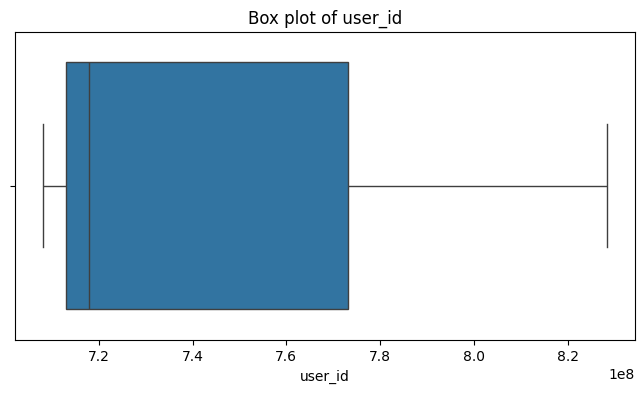

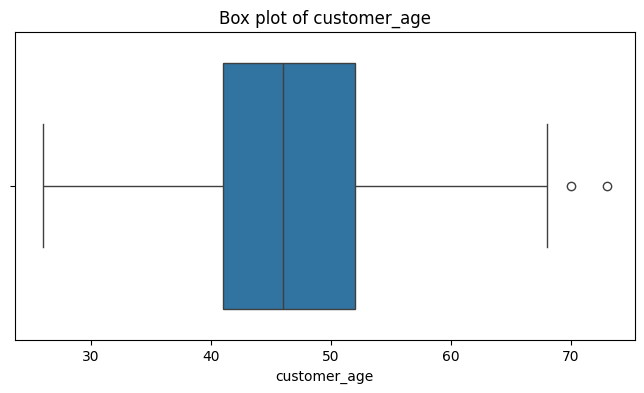

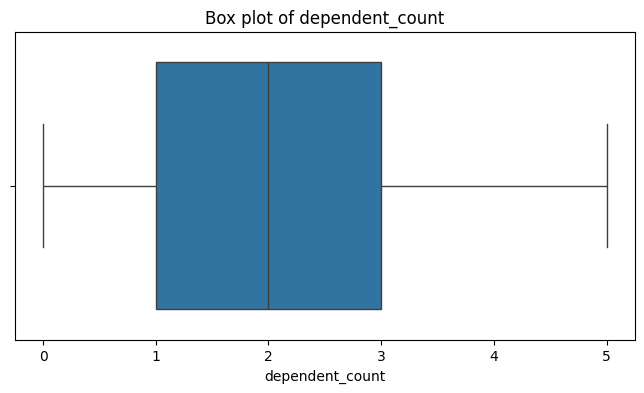

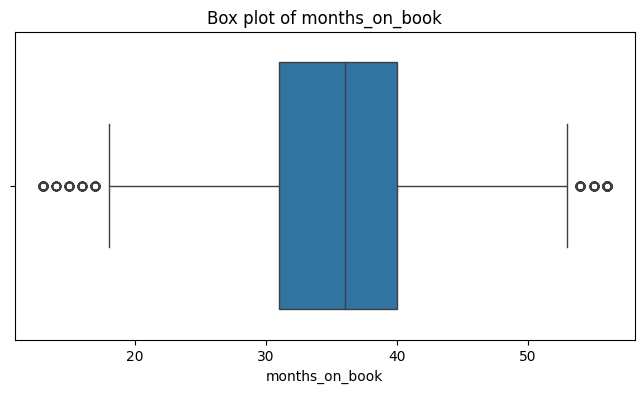

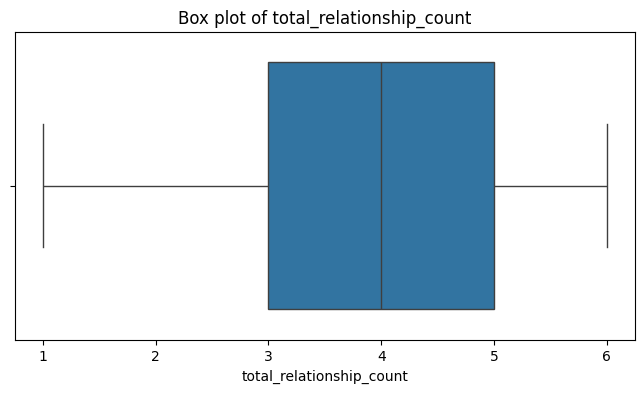

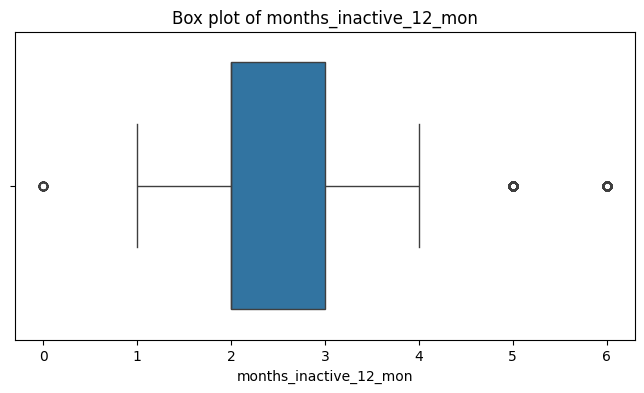

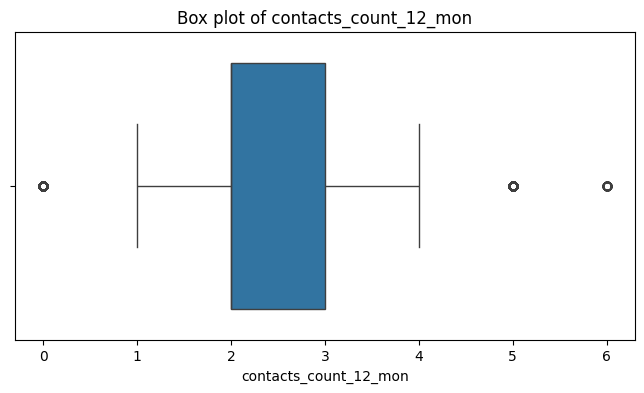

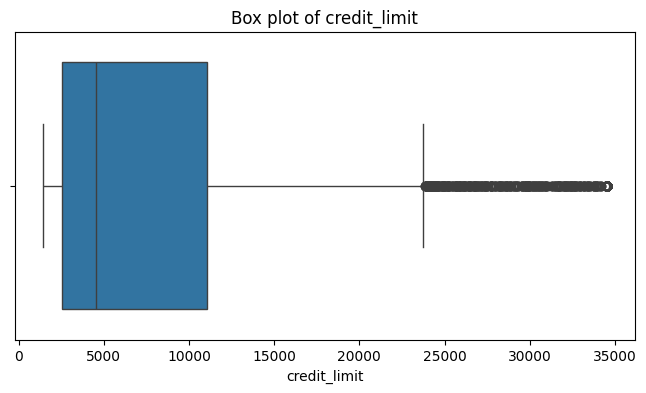

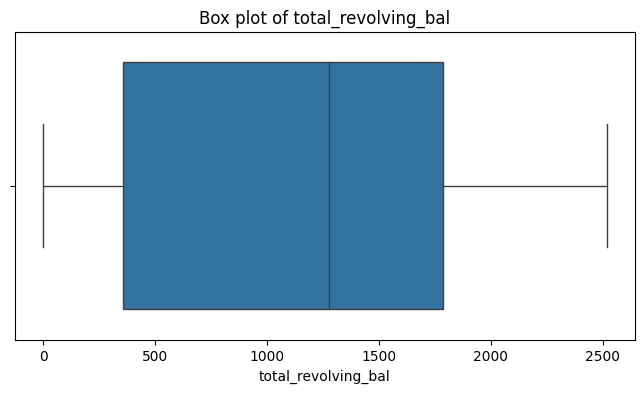

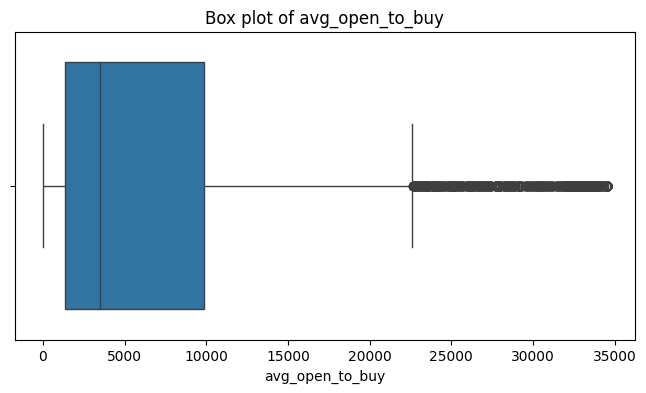

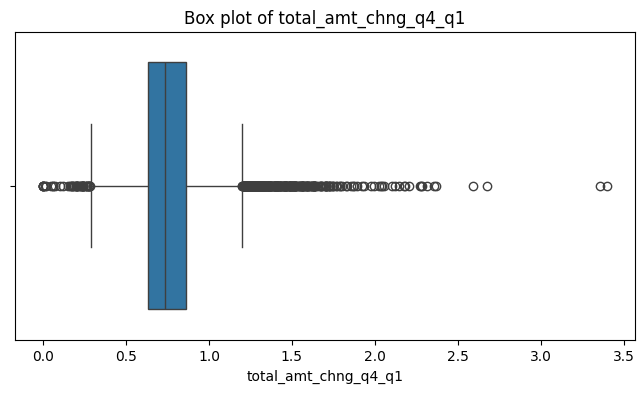

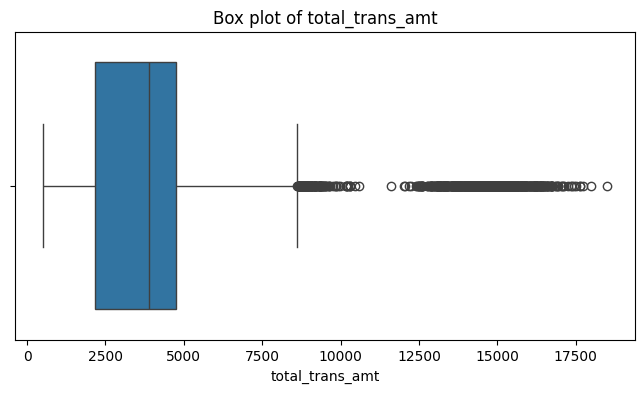

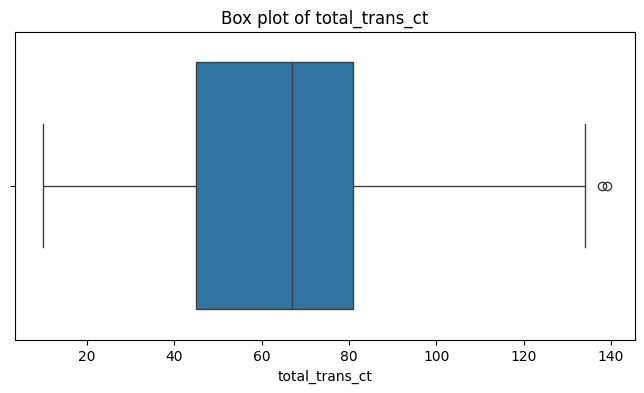

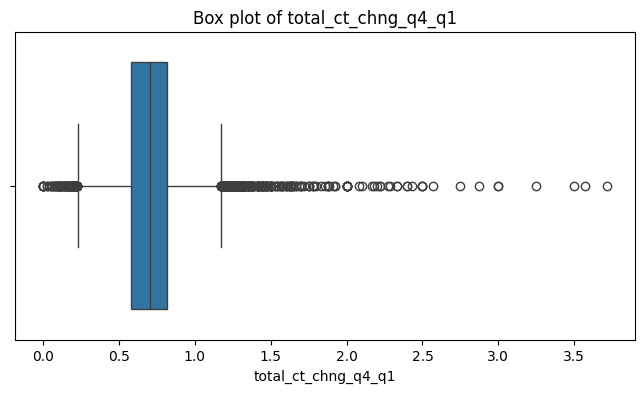

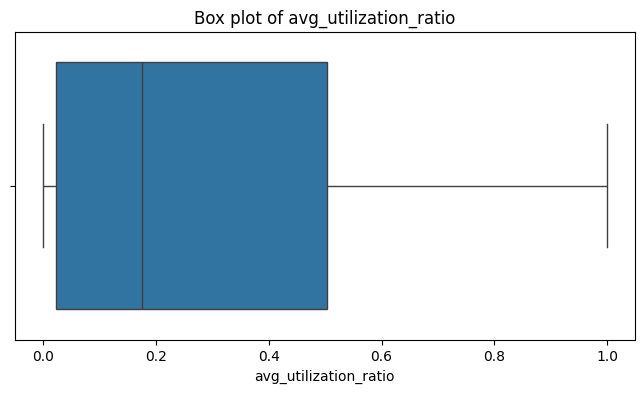

In [ ]:
# cek outlier dari data

# Function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Example usage for numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns

import matplotlib.pyplot as plt
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
    plt.show()

# EDA

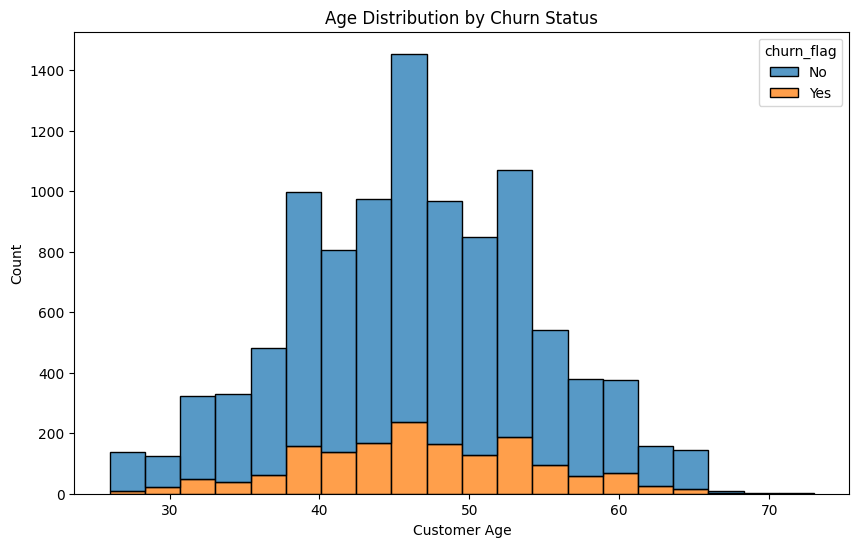

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='customer_age', hue='churn_flag', multiple='stack', bins=20)
plt.title('Age Distribution by Churn Status')
plt.xlabel('Customer Age')
plt.ylabel('Count')
plt.show()

In [ ]:
# Churn rate by age group
df['age_group'] = pd.cut(df['customer_age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70-80'])
churn_by_age = df.groupby('age_group')['churn_flag'].value_counts(normalize=True).unstack().fillna(0)
churn_by_age['Churn_Rate'] = churn_by_age['Yes']
print("\nChurn Rate by Age Group:")
print(churn_by_age[['Churn_Rate']])


Churn Rate by Age Group:
churn_flag  Churn_Rate
age_group             
20-30         0.120755
30-40         0.145403
40-50         0.167455
50-60         0.167602
60-70         0.143564
70-80         0.000000


/tmp/ipython-input-18-2367795945.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_age = df.groupby('age_group')['churn_flag'].value_counts(normalize=True).unstack().fillna(0)


**Insight dari distribusi Usia dan Churn**
- Distribusi usia pelanggan terpusat antara 40 hingga 60 tahun, dengan paling banyak di usia sekitar 45–50 tahun.

- Churn Rate tertinggi berada di kelompok usia 50–60 tahun (16.76%) dan 40–50 tahun (16.74%).

- Churn paling rendah di kelompok 20–30 tahun (12.08%).

Pelanggan berusia 40–60 tahun memiliki kemungkinan churn yang lebih tinggi dibanding kelompok usia lainnya. Segmentasi dan strategi retensi harus difokuskan pada rentang usia ini.

In [ ]:
df['income_category'].value_counts(normalize=True)

income_category
Less than $40K    0.351634
$40K - $60K       0.176755
$80K - $120K      0.151575
$60K - $80K       0.138442
Unknown           0.109805
$120K +           0.071788
Name: proportion, dtype: float64

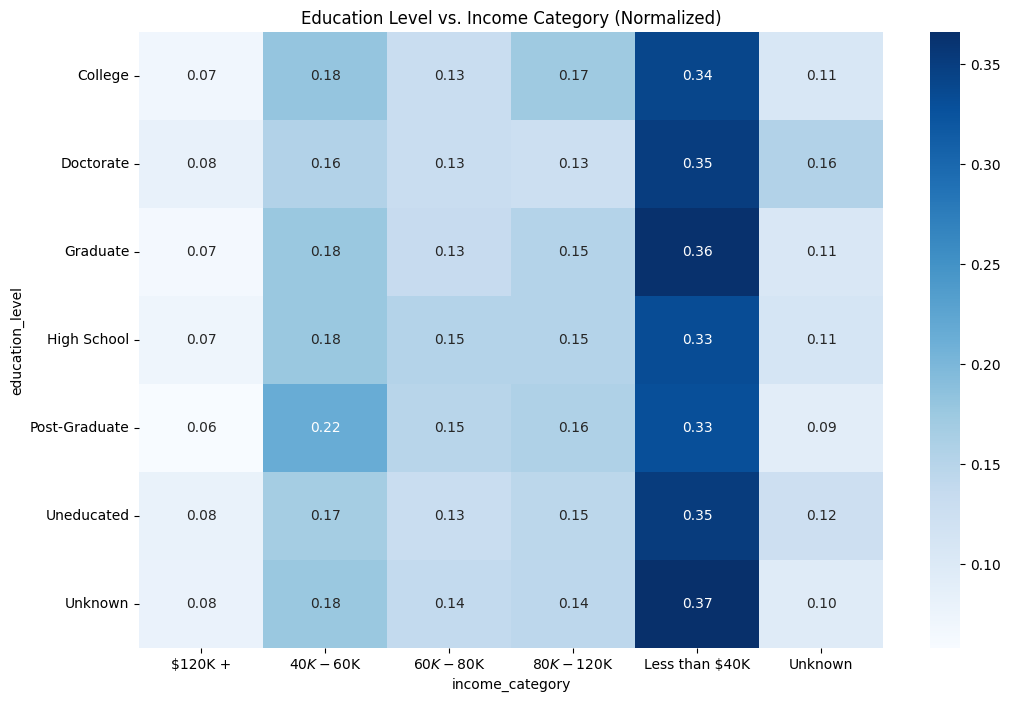

In [ ]:
# Education Level and Income Category vs. Churn
edu_income = pd.crosstab(df['education_level'], df['income_category'], normalize='index')
plt.figure(figsize=(12, 8))
sns.heatmap(edu_income, annot=True, cmap='Blues', fmt='.2f')
plt.title('Education Level vs. Income Category (Normalized)')
plt.show()

In [ ]:
churn_by_edu = df.groupby('education_level')['churn_flag'].value_counts(normalize=True).unstack().fillna(0)
churn_by_income = df.groupby('income_category')['churn_flag'].value_counts(normalize=True).unstack().fillna(0)
print("\nChurn Rate by Education Level:")
print(churn_by_edu[['Yes']])
print("\nChurn Rate by Income Category:")
print(churn_by_income[['Yes']])


Churn Rate by Education Level:
churn_flag            Yes
education_level          
College          0.152024
Doctorate        0.210643
Graduate         0.155691
High School      0.152012
Post-Graduate    0.178295
Uneducated       0.159381
Unknown          0.168532

Churn Rate by Income Category:
churn_flag            Yes
income_category          
$120K +          0.173315
$40K - $60K      0.151397
$60K - $80K      0.134807
$80K - $120K     0.157655
Less than $40K   0.171862
Unknown          0.168165


**Insight dari Income Category vs Churn**

- Pelanggan dengan pendapatan **tertinggi** (`$120K+`) dan **terendah** (`< $40K`) sama-sama memiliki **churn rate yang tinggi**, yaitu sekitar **17.1%–17.3%**.
- Sementara itu, pelanggan dengan pendapatan **menengah** (`$60K – $80K`) justru memiliki **churn rate terendah**, yaitu sebesar **13.48%**.

Pelanggan dengan pendapatan menengah cenderung lebih loyal, sementara yang sangat kaya atau sangat miskin lebih berisiko churn.

**Insight dari Tingkat Pendidikan vs Churn**

- Heatmap menunjukkan hampir semua tingkat pendidikan memiliki proporsi pendapatan terbesar di kategori Less than $40K.

- Pendidikan Doctorate (21.06%) dan Post-Graduate (17.83%) memiliki churn tertinggi.

- Pendidikan High School (15.2%) dan Graduate (15.5%) memiliki churn lebih rendah.

Walaupun pendidikan tinggi umumnya diasosiasikan dengan pendapatan lebih besar, pelanggan dengan pendidikan lebih tinggi justru cenderung churn lebih besar. Mungkin karena ekspektasi layanan yang lebih tinggi atau lebih mudah pindah ke penyedia lain.

In [ ]:
# Churn by Gender
churn_by_gender = df.groupby('gender')['churn_flag'].value_counts(normalize=True).unstack().fillna(0)
print("\nChurn Rate by Gender:")
print(churn_by_gender[['Yes']])


Churn Rate by Gender:
churn_flag       Yes
gender              
F           0.173572
M           0.146152


**Insight Gender vs Churn**

- Perempuan (17.36%) lebih banyak churn dibanding laki-laki (14.62%).

Perlu analisis lebih lanjut mengapa perempuan lebih berisiko churn. Mungkin terkait preferensi layanan, komunikasi, atau penawaran produk.

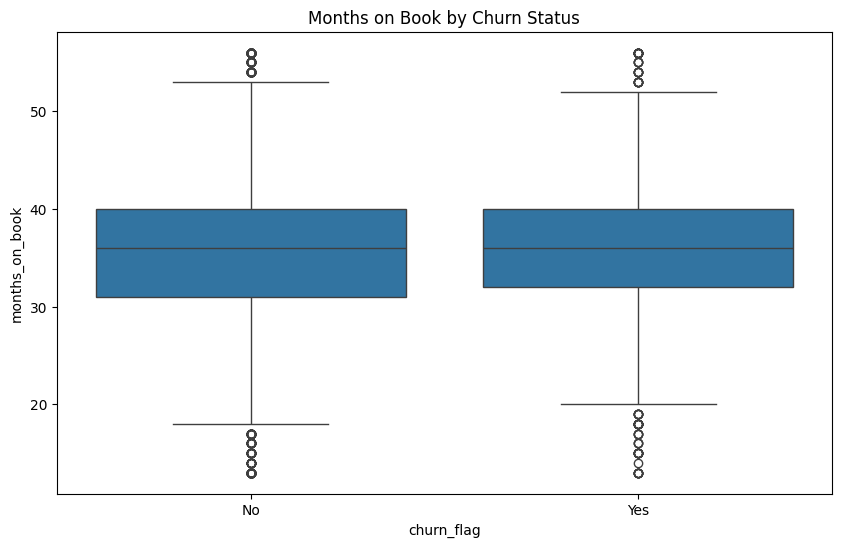

In [ ]:
# Months on Book vs. Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn_flag', y='months_on_book', data=df)
plt.title('Months on Book by Churn Status')
plt.show()

**Insight dari Months on Book vs Churn**

- Boxplot menunjukkan tidak ada perbedaan signifikan dalam lama menjadi nasabah antara churn dan tidak churn.

Durasi menjadi nasabah tidak berkorelasi langsung dengan churn. Pelanggan lama tidak selalu lebih loyal — perlu pendekatan retensi lebih personal.

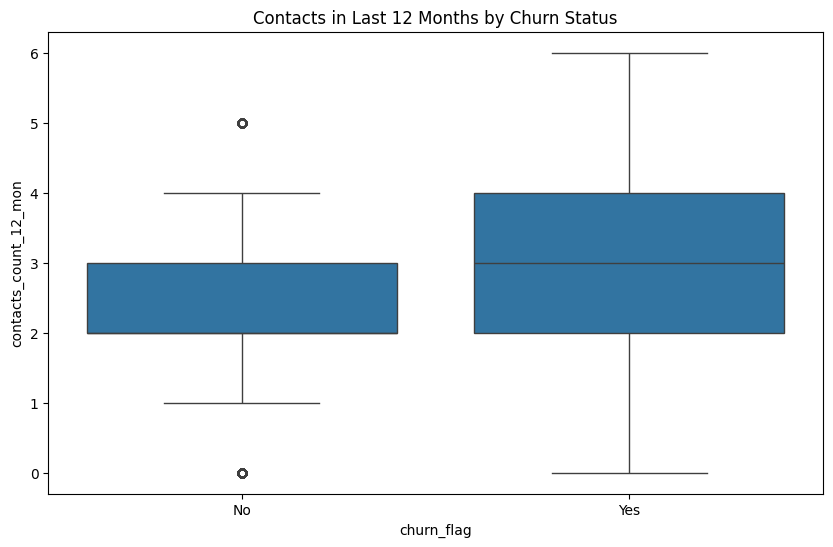

In [ ]:
# Contacts in Last 12 Months vs. Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn_flag', y='contacts_count_12_mon', data=df)
plt.title('Contacts in Last 12 Months by Churn Status')
plt.show()

**Insight dari Kontak Bank vs Churn**

- Pelanggan yang churn memiliki jumlah kontak dengan bank yang lebih tinggi.

Pelanggan yang sering menghubungi bank justru cenderung churn. Ini bisa menjadi tanda ketidakpuasan atau masalah yang belum terselesaikan.

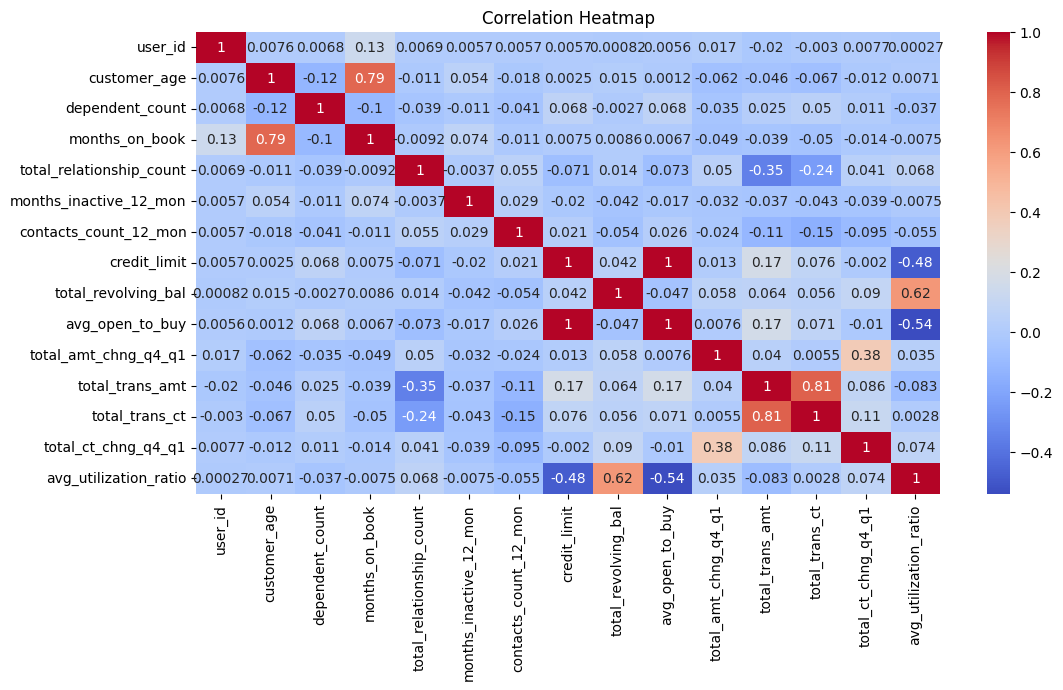

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


## Data distribution

In [ ]:
target_column = 'churn_flag'

ordinal_columns = [
    'education_level',
    'income_category',
    'card_category'
]

nominal_columns = [
    'gender',
    'marital_status'
]

category_columns = ordinal_columns + nominal_columns

numeric_columns = [
    'customer_age',
    'dependent_count',
    'months_on_book',
    'total_relationship_count',
    'months_inactive_12_mon',
    'contacts_count_12_mon',
    'credit_limit',
    'total_revolving_bal',
    'avg_open_to_buy',
    'total_amt_chng_q4_q1',
    'total_trans_amt',
    'total_trans_ct',
    'total_ct_chng_q4_q1',
    'avg_utilization_ratio'
]


In [ ]:
df.groupby(target_column).size()

churn_flag
No     8500
Yes    1627
dtype: int64

### Category

In [ ]:
df_dist_cat = pd.DataFrame()

for column in category_columns:
    df_temp = df.pivot_table(
        index=column,
        columns='churn_flag',
        values='user_id',
        aggfunc='count'
    )
    res = chi2_contingency(df_temp)
    coef = round(association(df_temp, method='cramer'), 2) # cramer's V

    index_tuples = [(column, x) for x in df_temp.index]
    df_temp.index = pd.MultiIndex.from_tuples(
        index_tuples,
        names=['column', 'value'],
    )

    df_temp['churn_proba'] = df_temp['Yes'] / (df_temp['No'] + df_temp['Yes'])
    df_temp['pvalue'] = ('' if res.pvalue > 0.05 else '< 0.05')
    df_temp['coef'] = coef

    df_dist_cat = pd.concat([df_dist_cat, df_temp])

df_dist_cat

churn_flag                        No   Yes  churn_proba  pvalue  coef
column          value                                                
education_level College          859   154     0.152024          0.04
                Doctorate        356    95     0.210643          0.04
                Graduate        2641   487     0.155691          0.04
                High School     1707   306     0.152012          0.04
                Post-Graduate    424    92     0.178295          0.04
                Uneducated      1250   237     0.159381          0.04
                Unknown         1263   256     0.168532          0.04
income_category $120K +          601   126     0.173315  < 0.05  0.04
                $40K - $60K     1519   271     0.151397  < 0.05  0.04
                $60K - $80K     1213   189     0.134807  < 0.05  0.04
                $80K - $120K    1293   242     0.157655  < 0.05  0.04
                Less than $40K  2949   612     0.171862  < 0.05  0.04
                Unknown          925   187     0.168165  < 0.05  0.04
card_category   Blue            7917  1519     0.160979          0.01
                Gold              95    21     0.181034          0.01
                Platinum          15     5     0.250000          0.01
                Silver           473    82     0.147748          0.01
gender          F               4428   930     0.173572  < 0.05  0.04
                M               4072   697     0.146152  < 0.05  0.04
marital_status  Divorced         627   121     0.161765          0.02
                Married         3978   709     0.151269          0.02
                Single          3275   668     0.169414          0.02
                Unknown          620   129     0.172230          0.02

### Numeric

In [ ]:
def show_distribution_numeric(column):
    res = ttest_ind(
        df[df['churn_flag'] == 'No'][column],
        df[df['churn_flag'] == 'Yes'][column],
        equal_var=False,
        alternative='two-sided',
    )
    print(f'p-value: {res.pvalue:.2f}')

    # Plot
    plt.figure(figsize=(6, 5))
    sns.violinplot(
        data=df,
        x=column,
        y='churn_flag',
        hue='churn_flag',
        split=True,
        inner='quart',
        palette={'Yes': HEX_RED, 'No': HEX_BLUE},
        orient='h'
    )
    plt.title(f'Distribution of {column} by Churn')
    plt.xlabel(column)
    plt.ylabel('churn_flag')
    plt.legend(title='churn_flag', loc='lower right')
    plt.tight_layout()
    plt.show()


p-value: 0.00


/tmp/ipython-input-28-2748156508.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='churn_flag', loc='lower right')


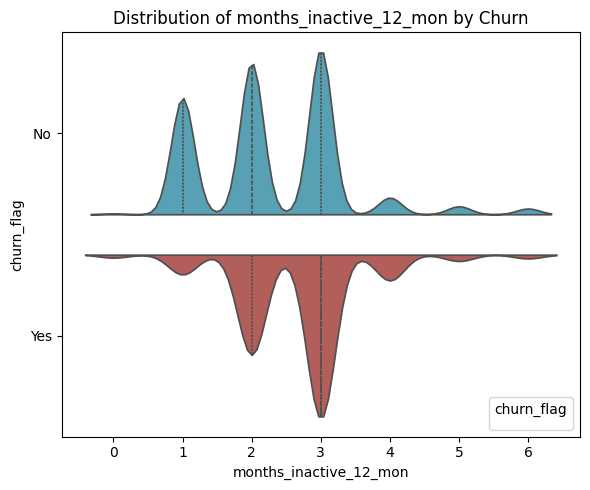

In [ ]:
show_distribution_numeric('months_inactive_12_mon')

p-value: 0.06


/tmp/ipython-input-28-2748156508.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='churn_flag', loc='lower right')


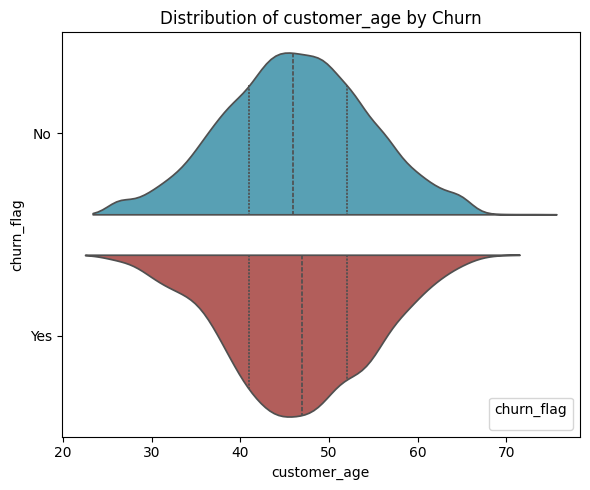

In [ ]:
show_distribution_numeric('customer_age')

p-value: 0.00


/tmp/ipython-input-28-2748156508.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='churn_flag', loc='lower right')


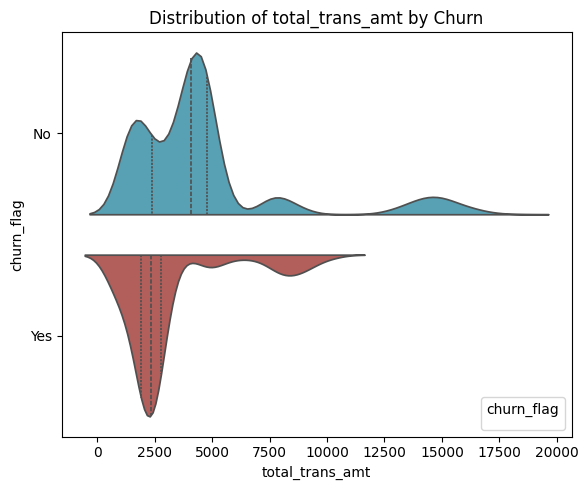

In [ ]:
show_distribution_numeric('total_trans_amt')

p-value: 0.00


/tmp/ipython-input-28-2748156508.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='churn_flag', loc='lower right')


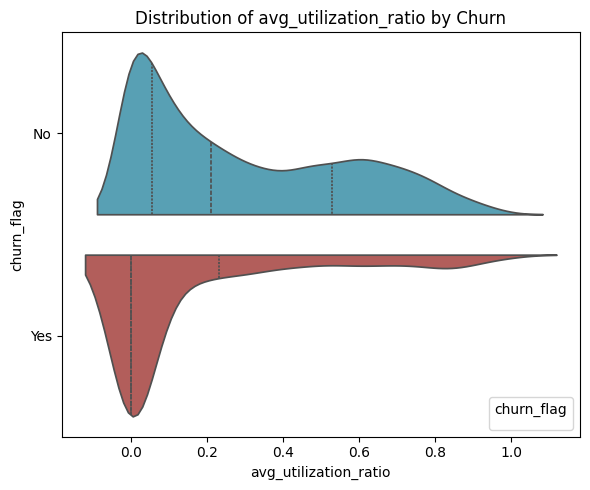

In [ ]:
show_distribution_numeric('avg_utilization_ratio')

## Bivariate

### Category & category

In [ ]:
def show_relationship_category_category(column1, column2):
    df_temp = df.pivot_table(
        index=column1,
        columns=column2,
        values='user_id',
        aggfunc='count',
    )
    df_temp = df_temp.fillna(0).astype(int)

    res = chi2_contingency(df_temp)
    coef = round(association(df_temp, method='cramer'), 2)

    return df_temp, ('' if res.pvalue > 0.05 else '< 0.05'), coef


In [ ]:
df_corr_cat_cat = pd.DataFrame()

for i in range(len(category_columns)):
    column1 = category_columns[i]
    for j in range(i + 1, len(category_columns)):
        column2 = category_columns[j]
        _, pvalue, coef = show_relationship_category_category(column1, column2)

        df_temp = pd.DataFrame({
            'column1': [column1],
            'column2': [column2],
            'pvalue': [pvalue],
            'coef': [coef],
        })
        df_corr_cat_cat = pd.concat([df_corr_cat_cat, df_temp], ignore_index=True)

df_corr_cat_cat


column1          column2  pvalue  coef
0  education_level  income_category  < 0.05  0.03
1  education_level    card_category          0.02
2  education_level           gender          0.03
3  education_level   marital_status          0.03
4  income_category    card_category  < 0.05  0.06
5  income_category           gender  < 0.05  0.84
6  income_category   marital_status          0.02
7    card_category           gender  < 0.05  0.09
8    card_category   marital_status  < 0.05  0.03
9           gender   marital_status          0.02

p-value: 
Cramer's V: 0.02


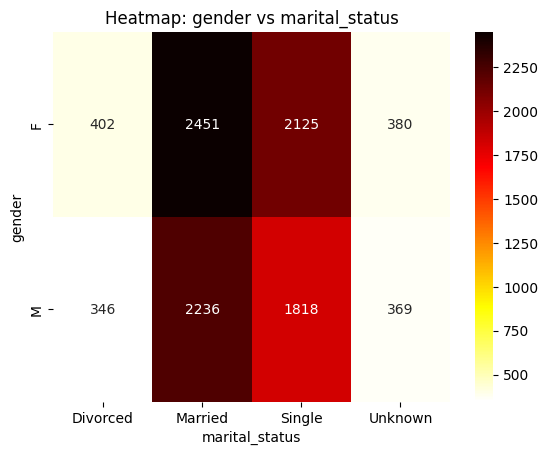

In [ ]:
df_temp, pvalue, coef = show_relationship_category_category(
    'gender',
    'marital_status',
)
print('p-value:', pvalue)
print("Cramer's V:", coef)

sns.heatmap(df_temp, cmap='hot_r', annot=True, fmt='.0f')
plt.title('Heatmap: gender vs marital_status')
plt.show()


<Axes: xlabel='column2', ylabel='column1'>

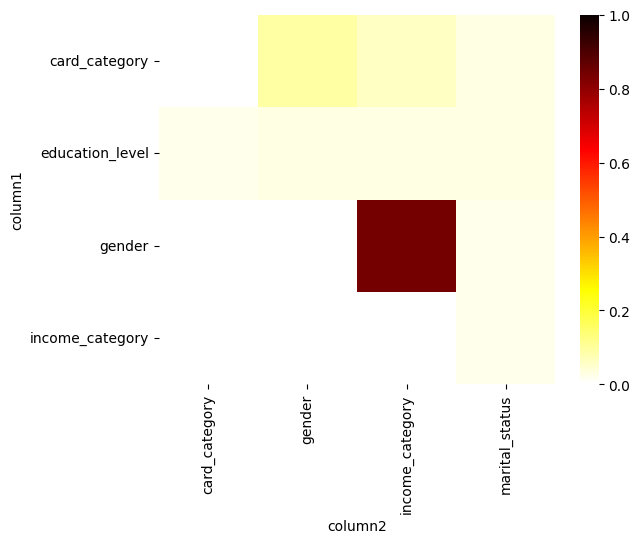

In [ ]:
df_temp = df_corr_cat_cat.pivot_table(
  index='column1',
  columns='column2',
  values='coef',
)

for column1 in df_corr_cat_cat['column1']:
  for column2 in df_corr_cat_cat['column2']:
    if np.isnan(df_temp.loc[column1, column2]) and column1 < column2:
      df_temp.loc[column1, column2] = df_temp.loc[column2, column1]
      df_temp.loc[column2, column1] = None

sns.heatmap(
  df_temp,
  vmin = 0,
  vmax = 1,
  cmap = 'hot_r',
)

INSIGHT

- No strong multicollinearity between categorical features.

- All columns are retained for modeling due to business relevance.

### Numeric & numeric

In [ ]:
df[numeric_columns].corr()

customer_age  dependent_count  months_on_book  \
customer_age                  1.000000        -0.122254        0.788912   
dependent_count              -0.122254         1.000000       -0.103062   
months_on_book                0.788912        -0.103062        1.000000   
total_relationship_count     -0.010931        -0.039076       -0.009203   
months_inactive_12_mon        0.054361        -0.010768        0.074164   
contacts_count_12_mon        -0.018452        -0.040505       -0.010774   
credit_limit                  0.002476         0.068065        0.007507   
total_revolving_bal           0.014780        -0.002688        0.008623   
avg_open_to_buy               0.001151         0.068291        0.006732   
total_amt_chng_q4_q1         -0.062042        -0.035439       -0.048959   
total_trans_amt              -0.046446         0.025046       -0.038591   
total_trans_ct               -0.067097         0.049912       -0.049819   
total_ct_chng_q4_q1          -0.012143         0.011087       -0.014072   
avg_utilization_ratio         0.007114        -0.037135       -0.007541   

                          total_relationship_count  months_inactive_12_mon  \
customer_age                             -0.010931                0.054361   
dependent_count                          -0.039076               -0.010768   
months_on_book                           -0.009203                0.074164   
total_relationship_count                  1.000000               -0.003675   
months_inactive_12_mon                   -0.003675                1.000000   
contacts_count_12_mon                     0.055203                0.029493   
credit_limit                             -0.071386               -0.020394   
total_revolving_bal                       0.013726               -0.042210   
avg_open_to_buy                          -0.072601               -0.016605   
total_amt_chng_q4_q1                      0.050119               -0.032247   
total_trans_amt                          -0.347229               -0.036982   
total_trans_ct                           -0.241891               -0.042787   
total_ct_chng_q4_q1                       0.040831               -0.038989   
avg_utilization_ratio                     0.067663               -0.007503   

                          contacts_count_12_mon  credit_limit  \
customer_age                          -0.018452      0.002476   
dependent_count                       -0.040505      0.068065   
months_on_book                        -0.010774      0.007507   
total_relationship_count               0.055203     -0.071386   
months_inactive_12_mon                 0.029493     -0.020394   
contacts_count_12_mon                  1.000000      0.020817   
credit_limit                           0.020817      1.000000   
total_revolving_bal                   -0.053913      0.042493   
avg_open_to_buy                        0.025646      0.995981   
total_amt_chng_q4_q1                  -0.024445      0.012813   
total_trans_amt                       -0.112774      0.171730   
total_trans_ct                        -0.152213      0.075927   
total_ct_chng_q4_q1                   -0.094997     -0.002020   
avg_utilization_ratio                 -0.055471     -0.482965   

                          total_revolving_bal  avg_open_to_buy  \
customer_age                         0.014780         0.001151   
dependent_count                     -0.002688         0.068291   
months_on_book                       0.008623         0.006732   
total_relationship_count             0.013726        -0.072601   
months_inactive_12_mon              -0.042210        -0.016605   
contacts_count_12_mon               -0.053913         0.025646   
credit_limit                         0.042493         0.995981   
total_revolving_bal                  1.000000        -0.047167   
avg_open_to_buy                     -0.047167         1.000000   
total_amt_chng_q4_q1                 0.058174         0.007595   
total_trans_amt            

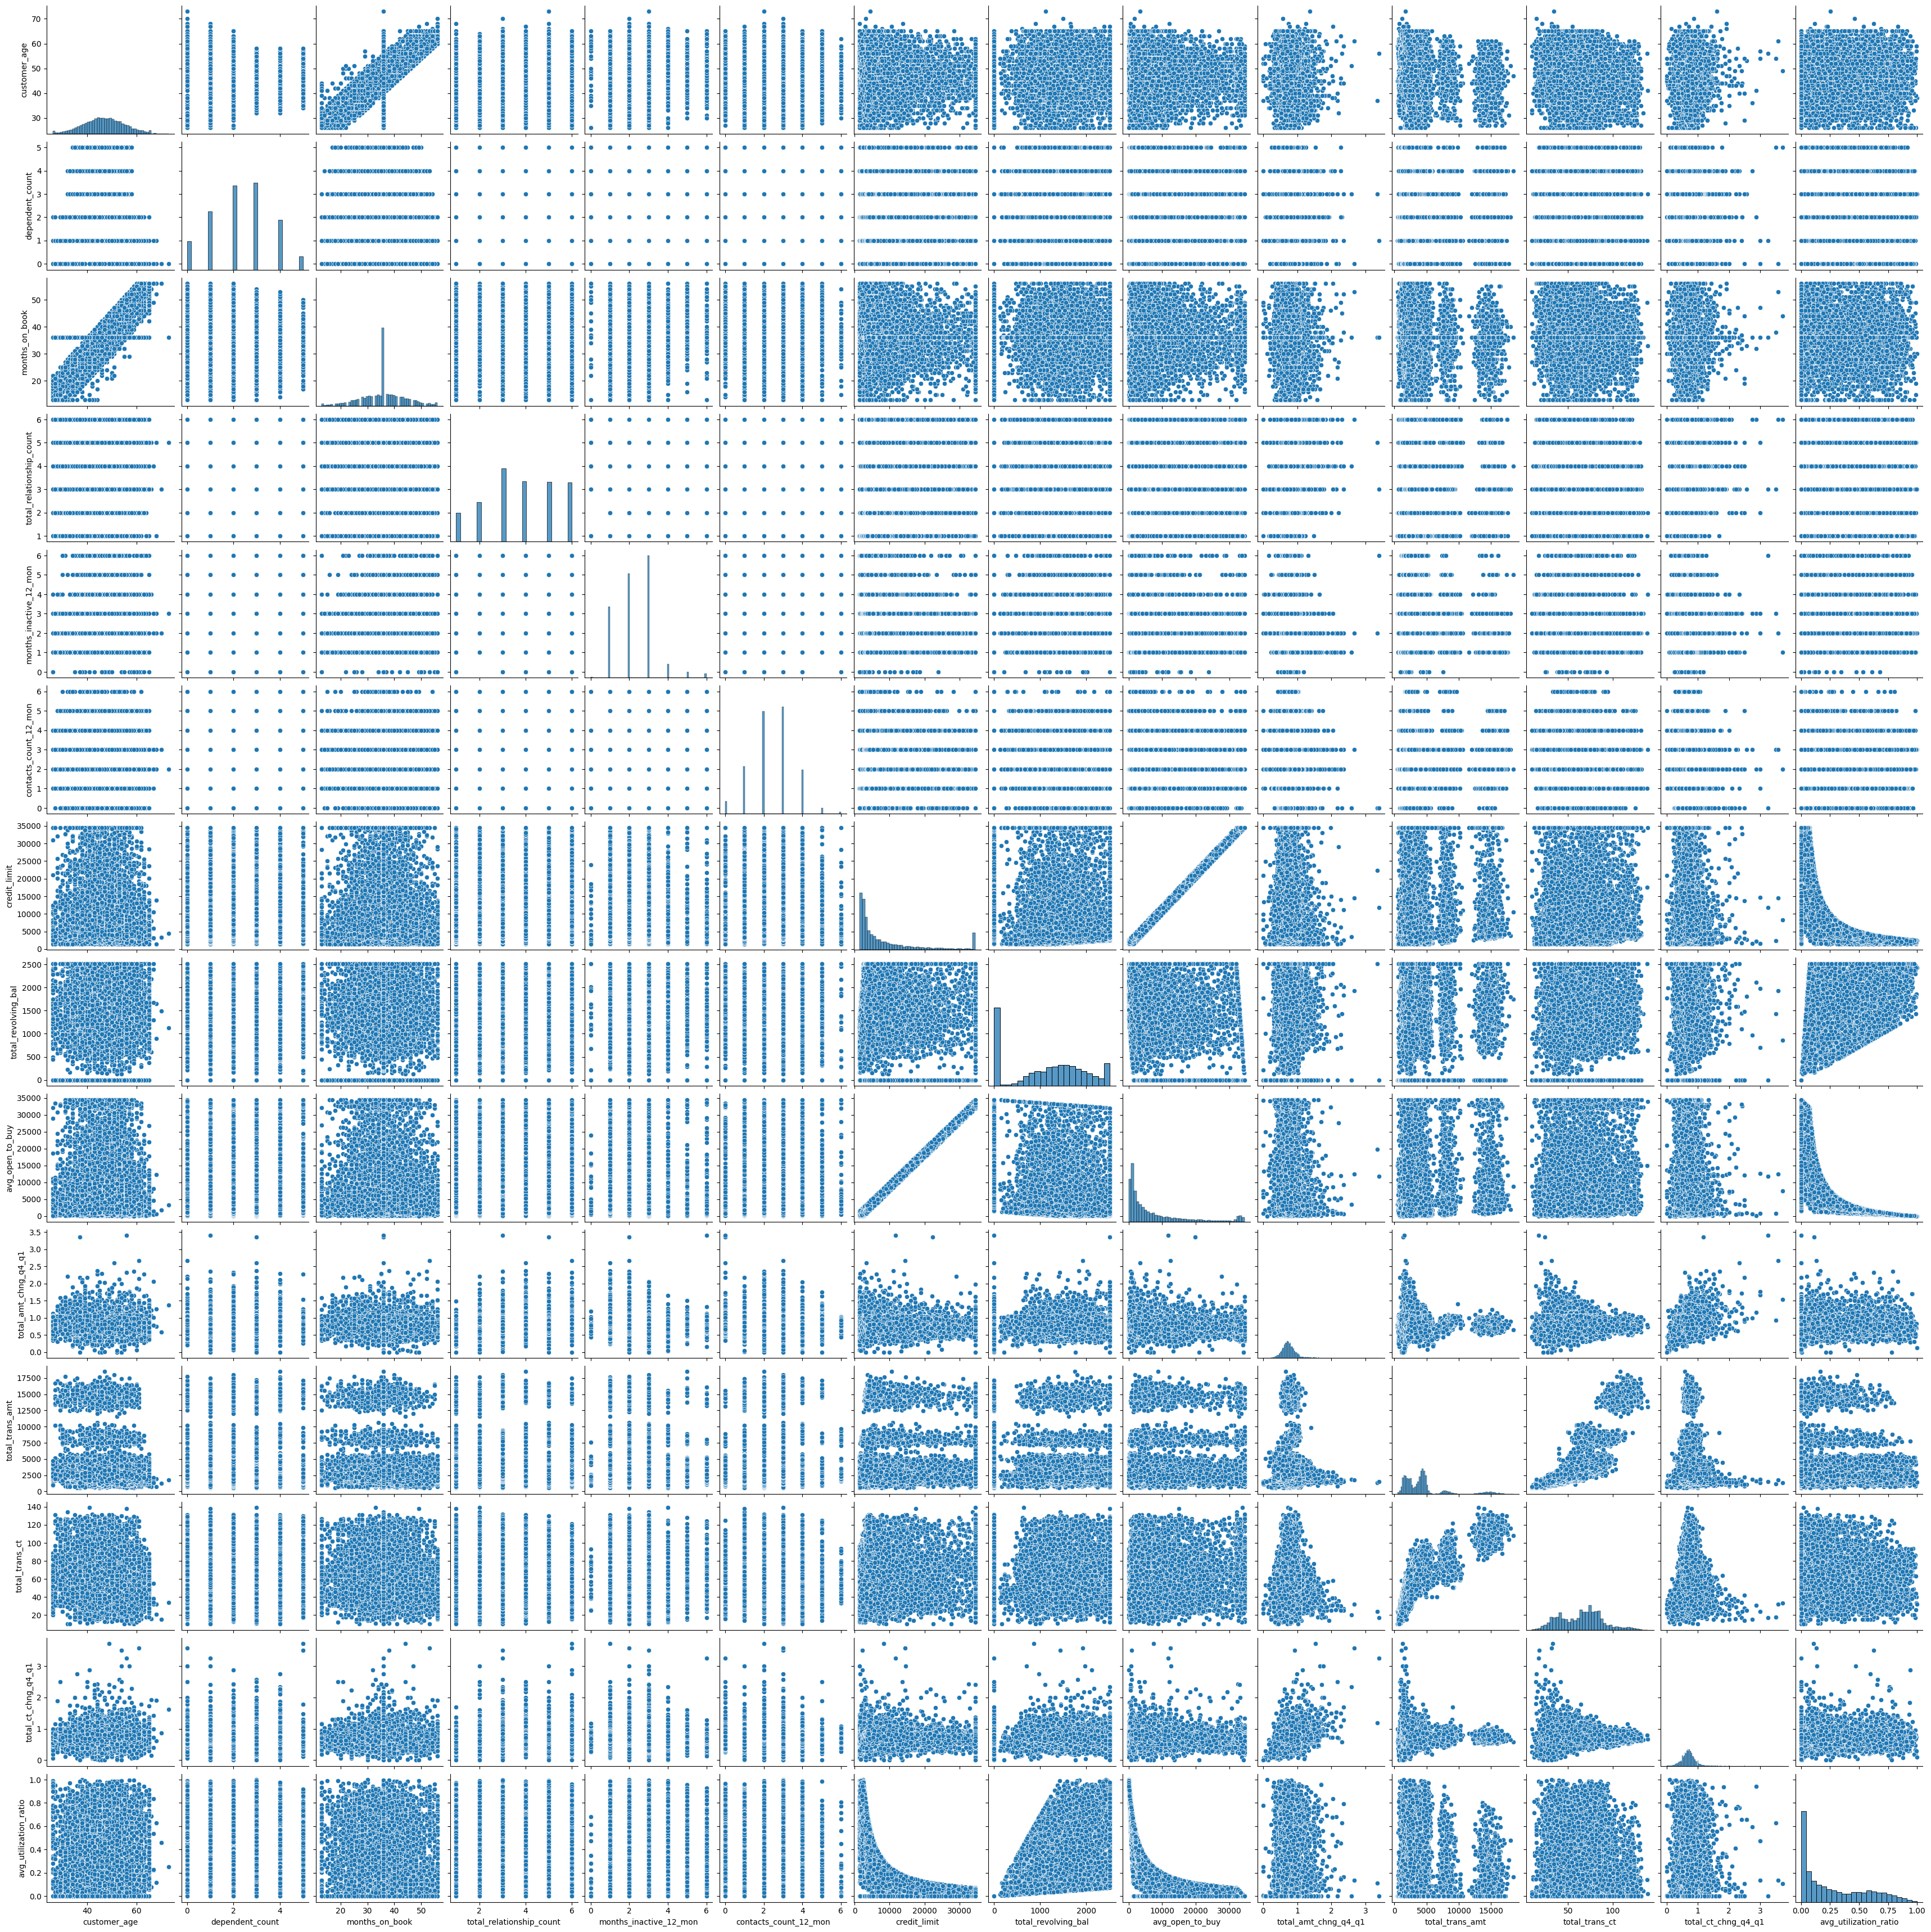

In [ ]:
sns.pairplot(df[numeric_columns])

### Category & numeric

In [ ]:
def show_relationship_category_numeric(cat, num):
        df_temp = df[[cat, num, 'user_id']].dropna().copy()
        qcut_result, bins = pd.qcut(
            df_temp[num],
            q=4,
            retbins=True,
            duplicates='drop'
        )
        num_bins = len(bins) - 1
        if num_bins < 2:
            raise ValueError("Too few bins to perform meaningful comparison.")

        labels = ['low', 'midlow', 'midhigh', 'high'][:num_bins]

        df_temp[num + '_bin'] = pd.qcut(
            df_temp[num],
            q=num_bins,
            labels=labels,
            duplicates='drop'
        )
        df_pivot = df_temp.pivot_table(
            index=cat,
            columns=num + '_bin',
            values='user_id',
            aggfunc='nunique',
            observed=False
        ).fillna(0).astype(int)

        # Chi-square & Cramer's V
        res = chi2_contingency(df_pivot)
        coef = round(association(df_pivot, method='cramer'), 2)

        return df_pivot, ('< 0.05' if res.pvalue < 0.05 else ''), coef

In [ ]:
df_corr_cat_num = pd.DataFrame()

for i in range(len(category_columns)):
  column1 = category_columns[i]
  for j in range(len(numeric_columns)):
    column2 = numeric_columns[j]
    _, pvalue, coef = show_relationship_category_numeric(column1, column2)

    df_temp = pd.DataFrame({
      'column1': [column1],
      'column2': [column2],
      'pvalue': [pvalue],
      'coef': [coef],
    })
    df_corr_cat_num = pd.concat([df_corr_cat_num, df_temp])

df_corr_cat_num

column1                   column2  pvalue  coef
0   education_level              customer_age  < 0.05  0.04
0   education_level           dependent_count          0.02
0   education_level            months_on_book          0.02
0   education_level  total_relationship_count          0.03
0   education_level    months_inactive_12_mon          0.01
..              ...                       ...     ...   ...
0    marital_status      total_amt_chng_q4_q1  < 0.05  0.03
0    marital_status           total_trans_amt  < 0.05  0.11
0    marital_status            total_trans_ct  < 0.05  0.09
0    marital_status       total_ct_chng_q4_q1          0.02
0    marital_status     avg_utilization_ratio  < 0.05  0.03

[70 rows x 4 columns]

/tmp/ipython-input-41-2546372501.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


<Axes: xlabel='months_on_book', ylabel='churn_flag'>

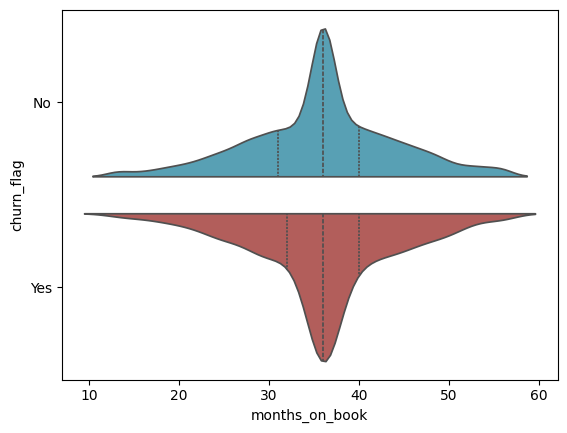

In [ ]:
sns.violinplot(
  df,
  x='months_on_book',
  y='churn_flag',
  split = True,
  inner = 'quart',
  palette = {'No': HEX_BLUE, 'Yes': HEX_RED},
  orient = 'h'
)

# Preprocess dataset

## Split dataset

In [ ]:

target_column = 'churn_flag'

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=target_column),
    df[target_column],
    test_size=0.2,
    random_state=11,
    stratify=df[target_column]
)

In [ ]:
X_train.shape

(8101, 21)

In [ ]:
X_test.shape

(2026, 21)

## Data transformation

### Drop columns

In [ ]:
dropped_columns = ['user_id']

In [ ]:
X_train = X_train.drop(columns=dropped_columns)
X_train.shape

(8101, 20)

In [ ]:
X_test = X_test.drop(columns=dropped_columns)
X_test.shape

(2026, 20)

### Encode target variable

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
['{0}: {1}'.format(i, v) for i, v in enumerate(encoder.classes_)]

['0: No', '1: Yes']

### Encode ordinal variables

In [ ]:
edu_order = [
    'Unknown', 'Uneducated', 'High School', 'College',
    'Graduate', 'Post-Graduate', 'Doctorate'
]
encoder_edu = OrdinalEncoder(categories=[edu_order])
X_train['education_level'] = encoder_edu.fit_transform(X_train[['education_level']])
X_test['education_level'] = encoder_edu.transform(X_test[['education_level']])

In [ ]:
income_order = [
    'Unknown', 'Less than $40K', '$40K - $60K',
    '$60K - $80K', '$80K - $120K', '$120K +'
]
encoder_income = OrdinalEncoder(categories=[income_order])
X_train['income_category'] = encoder_income.fit_transform(X_train[['income_category']])
X_test['income_category'] = encoder_income.transform(X_test[['income_category']])

In [ ]:
card_order = ['Blue', 'Silver', 'Gold', 'Platinum']
encoder_card = OrdinalEncoder(categories=[card_order])
X_train['card_category'] = encoder_card.fit_transform(X_train[['card_category']])
X_test['card_category'] = encoder_card.transform(X_test[['card_category']])

In [ ]:
binary_map_gender = {'F': 0, 'M': 1}
X_train['gender'] = X_train['gender'].map(binary_map_gender)
X_test['gender'] = X_test['gender'].map(binary_map_gender)

binary_map_marital = {'Single': 0, 'Married': 1, 'Divorced': 2}
X_train['marital_status'] = X_train['marital_status'].map(binary_map_marital)
X_test['marital_status'] = X_test['marital_status'].map(binary_map_marital)

### Encode nominal variables

In [ ]:
def custom_feature_name(transformer_name, feature_name):
    return f'{feature_name}'

encoder = OneHotEncoder(drop='first', handle_unknown='ignore')


transformer = ColumnTransformer(
    transformers=[
        ('onehotencoder', encoder, nominal_columns),
    ],
    verbose_feature_names_out=False
)

transformed_train = transformer.fit_transform(X_train)

df_encoded_train = pd.DataFrame(
    transformed_train.toarray(),
    columns=transformer.get_feature_names_out(),
    index=X_train.index
)

X_train = pd.concat([X_train.drop(columns=nominal_columns), df_encoded_train], axis=1)
X_train.sample(5)

customer_age  dependent_count  education_level  income_category  \
9499            51                2              0.0              1.0   
179             59                1              1.0              2.0   
881             43                3              2.0              3.0   
9520            38                1              3.0              1.0   
1273            56                2              5.0              3.0   

      card_category  months_on_book  total_relationship_count  \
9499            0.0              46                         1   
179             0.0              36                         4   
881             0.0              36                         1   
9520            0.0              28                         2   
1273            0.0              49                         5   

      months_inactive_12_mon  contacts_count_12_mon  credit_limit  ...  \
9499                       6                      3        7744.0  ...   
179                        2                      3        3356.0  ...   
881                        3                      3        8663.0  ...   
9520                       2                      2        4623.0  ...   
1273                       3                      4        1438.3  ...   

      total_amt_chng_q4_q1  total_trans_amt  total_trans_ct  \
9499                 0.813            16059             124   
179                  0.350              999              28   
881                  0.639              916              33   
9520                 0.776            14730             118   
1273                 0.770             1446              38   

      total_ct_chng_q4_q1  avg_utilization_ratio  age_group  gender_1  \
9499                0.722                  0.244      50-60       0.0   
179                 0.556                  0.294      50-60       0.0   
881                 0.320                  0.033      40-50       1.0   
9520                0.735                  0.295      30-40       0.0   
1273                0.810                  0.000      50-60       1.0   

     marital_status_1.0  marital_status_2.0  marital_status_nan  
9499                1.0                 0.0                 0.0  
179                 1.0                 0.0                 0.0  
881                 1.0                 0.0                 0.0  
9520                0.0                 0.0                 0.0  
1273                1.0                 0.0                 0.0  

[5 rows x 22 columns]

In [ ]:
transformed_test = transformer.transform(X_test)

df_encoded_test = pd.DataFrame(
    transformed_test.toarray(),
    columns=transformer.get_feature_names_out(),
    index=X_test.index
)

X_test = pd.concat([X_test.drop(columns=nominal_columns), df_encoded_test], axis=1)
X_test.sample(5)

customer_age  dependent_count  education_level  income_category  \
2371            48                4              3.0              1.0   
54              56                2              4.0              5.0   
6424            47                2              4.0              1.0   
4727            45                3              6.0              0.0   
1610            52                1              4.0              5.0   

      card_category  months_on_book  total_relationship_count  \
2371            0.0              38                         4   
54              0.0              36                         1   
6424            0.0              34                         6   
4727            0.0              33                         6   
1610            0.0              44                         6   

      months_inactive_12_mon  contacts_count_12_mon  credit_limit  ...  \
2371                       3                      3        4894.0  ...   
54                         3                      3       15769.0  ...   
6424                       2                      2        2190.0  ...   
4727                       3                      2       12587.0  ...   
1610                       1                      4        9274.0  ...   

      total_amt_chng_q4_q1  total_trans_amt  total_trans_ct  \
2371                 0.780             3277              67   
54                   1.041              602              15   
6424                 0.630             4416              68   
4727                 0.576             3914              83   
1610                 0.776             2048              59   

      total_ct_chng_q4_q1  avg_utilization_ratio  age_group  gender_1  \
2371                0.558                  0.308      40-50       0.0   
54                  0.364                  0.000      50-60       1.0   
6424                0.581                  0.000      40-50       0.0   
4727                0.766                  0.065      40-50       0.0   
1610                0.639                  0.226      50-60       1.0   

     marital_status_1.0  marital_status_2.0  marital_status_nan  
2371                0.0                 0.0                 0.0  
54                  1.0                 0.0                 0.0  
6424                1.0                 0.0                 0.0  
4727                0.0                 1.0                 0.0  
1610                1.0                 0.0                 0.0  

[5 rows x 22 columns]

### Scale numeric variables

In [ ]:
scaler = MinMaxScaler()

X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [ ]:
X_train[numeric_columns].sample(5)

customer_age  dependent_count  months_on_book  total_relationship_count  \
7836      0.446809              1.0        0.674419                       0.4   
6212      0.595745              0.2        0.627907                       0.6   
3391      0.404255              0.4        0.534884                       0.6   
1659      0.468085              0.6        0.651163                       0.8   
2208      0.531915              0.4        0.534884                       0.8   

      months_inactive_12_mon  contacts_count_12_mon  credit_limit  \
7836                0.833333               0.500000      0.087875   
6212                0.166667               0.333333      0.043464   
3391                0.333333               0.666667      0.190452   
1659                0.333333               0.333333      0.133313   
2208                0.333333               0.666667      1.000000   

      total_revolving_bal  avg_open_to_buy  total_amt_chng_q4_q1  \
7836             0.864521         0.062569              0.221372   
6212             0.503377         0.046340              0.181631   
3391             0.376242         0.196517              0.248749   
1659             0.377433         0.141657              0.213718   
2208             0.352801         0.974265              0.382396   

      total_trans_amt  total_trans_ct  total_ct_chng_q4_q1  \
7836         0.108379        0.263566             0.125740   
6212         0.210971        0.496124             0.137318   
3391         0.208357        0.395349             0.186861   
1659         0.080728        0.317829             0.146742   
2208         0.080616        0.248062             0.244750   

      avg_utilization_ratio  
7836               0.503518  
6212               0.443216  
3391               0.122613  
1659               0.162814  
2208               0.026131

In [ ]:
# Drop the 'age_group' column which was used for EDA and contains string values
X_train = X_train.drop(columns=['age_group'])
X_test = X_test.drop(columns=['age_group'])

# Select model

## Logistic regression

### Training model

In [ ]:
model = LogisticRegression(
  penalty = 'l2',
  C = 1.0,
  class_weight = 'balanced',
  random_state = 11,
  solver = 'lbfgs',
)

model.fit(X_train, y_train)

scores = cross_val_score(
  model,
  X_train,
  y_train,
  cv = 5,
  scoring = 'f1',
)

Mean : 0.646
STD : 0.012


<Axes: >

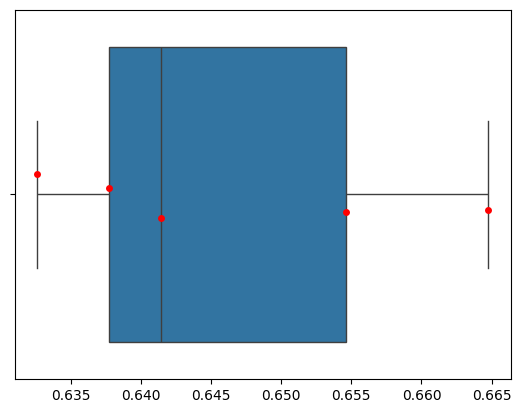

In [ ]:
print('Mean :', round(scores.mean(), 3))
print('STD :', round(scores.std(), 3))

sns.boxplot(x=scores, orient='h')
sns.stripplot(x=scores, color='red')

### Evaluation

In [ ]:
y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      6799
           1       0.52      0.85      0.65      1302

    accuracy                           0.85      8101
   macro avg       0.75      0.85      0.78      8101
weighted avg       0.90      0.85      0.86      8101



In [ ]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      1701
           1       0.50      0.82      0.62       325

    accuracy                           0.84      2026
   macro avg       0.73      0.83      0.76      2026
weighted avg       0.89      0.84      0.85      2026



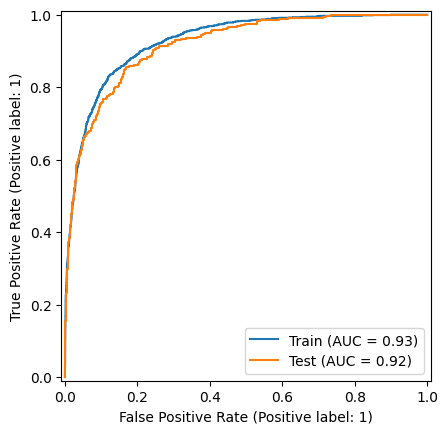

In [ ]:
auc_train = RocCurveDisplay.from_estimator(
  model,
  X_train,
  y_train,
  name='Train',
)

RocCurveDisplay.from_estimator(
  model,
  X_test,
  y_test,
  name='Test',
  ax=auc_train.ax_,
)

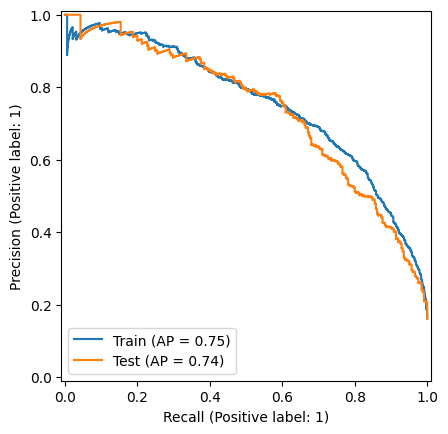

In [ ]:
auc_train = PrecisionRecallDisplay.from_estimator(
  model,
  X_train,
  y_train,
  name='Train',
)

PrecisionRecallDisplay.from_estimator(
  model,
  X_test,
  y_test,
  name='Test',
  ax=auc_train.ax_,
)

### Interpretation

In [ ]:
df_feature = pd.DataFrame({
  'feature': X_train.columns,
  'coef': model.coef_[0],
  'coef_abs': abs(model.coef_[0]),
})

df_feature.sort_values('coef_abs', ascending=False)

feature       coef   coef_abs
14            total_trans_ct -13.424819  13.424819
15       total_ct_chng_q4_q1  -7.821045   7.821045
13           total_trans_amt   6.875786   6.875786
8      contacts_count_12_mon   2.895176   2.895176
7     months_inactive_12_mon   2.809787   2.809787
10       total_revolving_bal  -1.837176   1.837176
6   total_relationship_count  -1.776462   1.776462
12      total_amt_chng_q4_q1  -1.713357   1.713357
17                  gender_1  -0.903571   0.903571
1            dependent_count   0.539553   0.539553
18        marital_status_1.0  -0.455353   0.455353
4              card_category   0.379849   0.379849
5             months_on_book  -0.341092   0.341092
16     avg_utilization_ratio  -0.306076   0.306076
9               credit_limit  -0.302139   0.302139
3            income_category   0.162149   0.162149
0               customer_age  -0.131551   0.131551
20        marital_status_nan  -0.118634   0.118634
19        marital_status_2.0  -0.035054   0.035054
11           avg_open_to_buy  -0.023922   0.023922
2            education_level   0.012555   0.012555

## Random Forest

In [ ]:
space = {
  'learning_rate': uniform(loc=0.3, scale=0.7),
  'gamma': uniform(loc=1, scale=8),
  'max_depth': randint(3, 12),
  'reg_lambda' : uniform(loc=0, scale=1),
  'reg_alpha' : randint(0, 180),
  'colsample_bytree' : uniform(loc=0.5, scale=0.5),
  'min_child_weight' : randint(0, 10),
  'n_estimators': [100, 140, 180],
}

In [ ]:
model = xgb.XGBClassifier(
  scale_pos_weight = (y_train.shape[0] - sum(y_train)) / sum(y_train),
)

hp = RandomizedSearchCV(
  model,
  space,
  n_iter = 10,
  scoring = 'f1',
  return_train_score = True,
  random_state = 11,
)

search = hp.fit(X_train, y_train)

In [ ]:
pd.DataFrame.from_dict(search.cv_results_).sort_values('rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.121982      0.026516         0.012319        0.001654   
3       0.112051      0.014680         0.011796        0.000212   
6       0.096204      0.003378         0.012482        0.001269   
4       0.100475      0.014323         0.013213        0.002074   
8       0.119378      0.012593         0.012086        0.000560   
2       0.111544      0.003450         0.012204        0.000699   
7       0.090518      0.002337         0.011583        0.000425   
5       0.072823      0.002393         0.011286        0.000490   
1       0.076122      0.007394         0.011745        0.001430   
9       0.232727      0.093234         0.018335        0.007678   

   param_colsample_bytree  param_gamma  param_learning_rate  param_max_depth  \
0                0.590135     1.155802             0.624253                4   
3                0.512575     8.370230             0.587639                9   
6                0.531843     3.916925             0.349016                4   
4                0.887415     4.864850             0.848316                3   
8                0.718120     6.862603             0.344021               11   
2                0.928577     2.320693             0.742634               11   
7                0.838765     8.906054             0.628749                4   
5                0.776192     8.592819             0.990671                4   
1                0.743686     8.534453             0.895557                7   
9                0.667370     5.014181             0.804396                4   

   param_min_child_weight  param_n_estimators  ...  mean_test_score  \
0                       7                 180  ...         0.843918   
3                       9                 180  ...         0.824275   
6                       2                 140  ...         0.819704   
4                       8                 140  ...         0.785768   
8                       6                 180  ...         0.785467   
2                       1                 180  ...         0.769965   
7                       1                 140  ...         0.764680   
5                       4                 100  ...         0.763020   
1                       2                 100  ...         0.761031   
9                       5                 180  ...         0.756745   

   std_test_score rank_test_score  split0_train_score  split1_train_score  \
0        0.005793               1            0.878748            0.885203   
3        0.008828               2            0.858114            0.861657   
6        0.009411               3            0.843750            0.856415   
4        0.017045               4            0.786699            0.791633   
8        0.014057               5            0.820300            0.802760   
2        0.010535               6            0.793522            0.791401   
7        0.007528               7            0.769291            0.790920   
5        0.015375               8            0.784584            0.771986   
1        0.015125               9            0.776604            0.762838   
9        0.015103              10            0.766008            0.760453   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.878788            0.879235            0.883173   
3            0.847357            0.854846            0.861643   
6            0.848536            0.842857            0.850614   
4            0.785002            0.809035            0.804748   
8            0.809582            0.805331            0.786937   
2            0.779180            0.795473            0.791984   
7            0.782046            0.785428            0.766706   
5            0.779148            0.790868            0.790584   
1            0.797412            0.792119            0.786661   
9            0.776013            0.775299            0.777558   

   mean_train_score  std_train_score  

In [ ]:
search.best_score_

np.float64(0.8439184584695049)

In [ ]:
model = search.best_estimator_
model.fit(X_train, y_train)
scores = cross_val_score(
  model,
  X_train,
  y_train,
  cv = 5,
  scoring = 'f1',
)

Mean : 0.844
STD : 0.006


<Axes: >

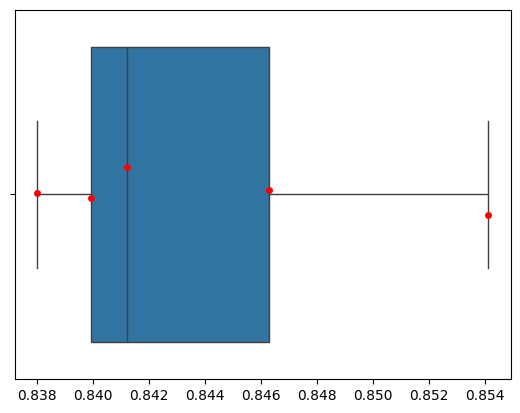

In [ ]:
print('Mean :', round(scores.mean(), 3))
print('STD :', round(scores.std(), 3))

sns.boxplot(x=scores, orient='h')
sns.stripplot(x=scores, color='red')

### Evaluation

In [ ]:
y_train_pred = model.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      6799
           1       0.83      0.98      0.90      1302

    accuracy                           0.96      8101
   macro avg       0.91      0.97      0.94      8101
weighted avg       0.97      0.96      0.96      8101



In [ ]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1701
           1       0.81      0.93      0.87       325

    accuracy                           0.95      2026
   macro avg       0.90      0.94      0.92      2026
weighted avg       0.96      0.95      0.95      2026



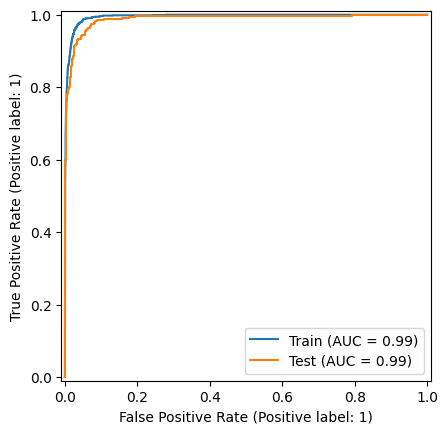

In [ ]:
# ROC Curve
auc_train = RocCurveDisplay.from_estimator(
    model,
    X_train,
    y_train,
    name='Train',
)

RocCurveDisplay.from_estimator(
    model,
    X_test,
    y_test,
    name='Test',
    ax=auc_train.ax_,
)

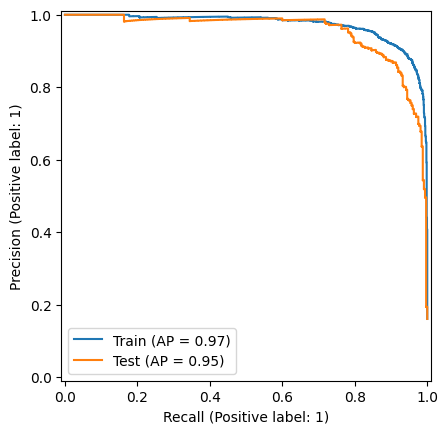

In [ ]:
# Precision-Recall Curve
auc_train = PrecisionRecallDisplay.from_estimator(
    model,
    X_train,
    y_train,
    name='Train',
)

PrecisionRecallDisplay.from_estimator(
    model,
    X_test,
    y_test,
    name='Test',
    ax=auc_train.ax_,
)

### Interpretation

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

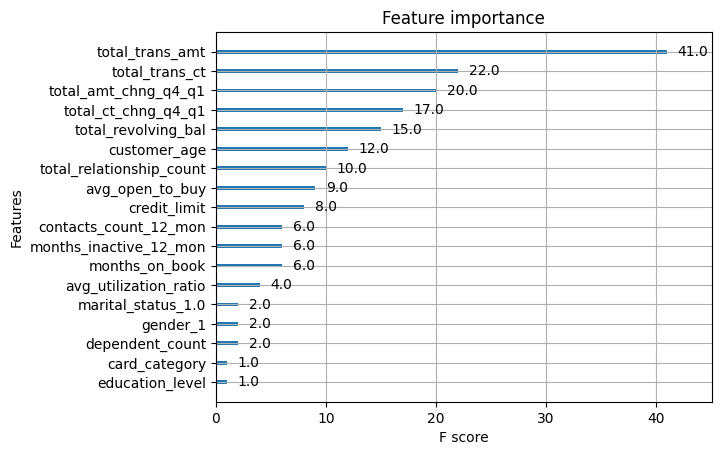

In [ ]:
xgb.plot_importance(model, importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

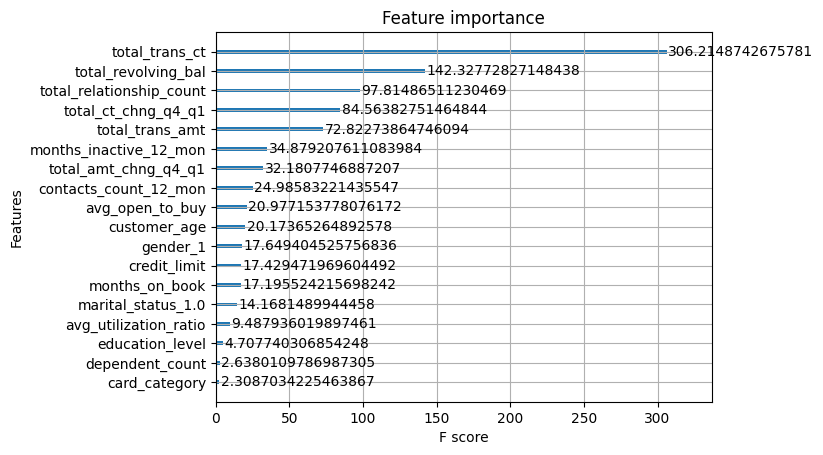

In [ ]:
xgb.plot_importance(model, importance_type='gain')

# Explain model with SHAP

In [ ]:
explainer = shap.TreeExplainer(
  model,
  X_train,
  feature_perturbation='interventional',
  model_output='probability',
)
explanation = explainer(X_train)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.Explainer(model, X_train)

## Feature importance

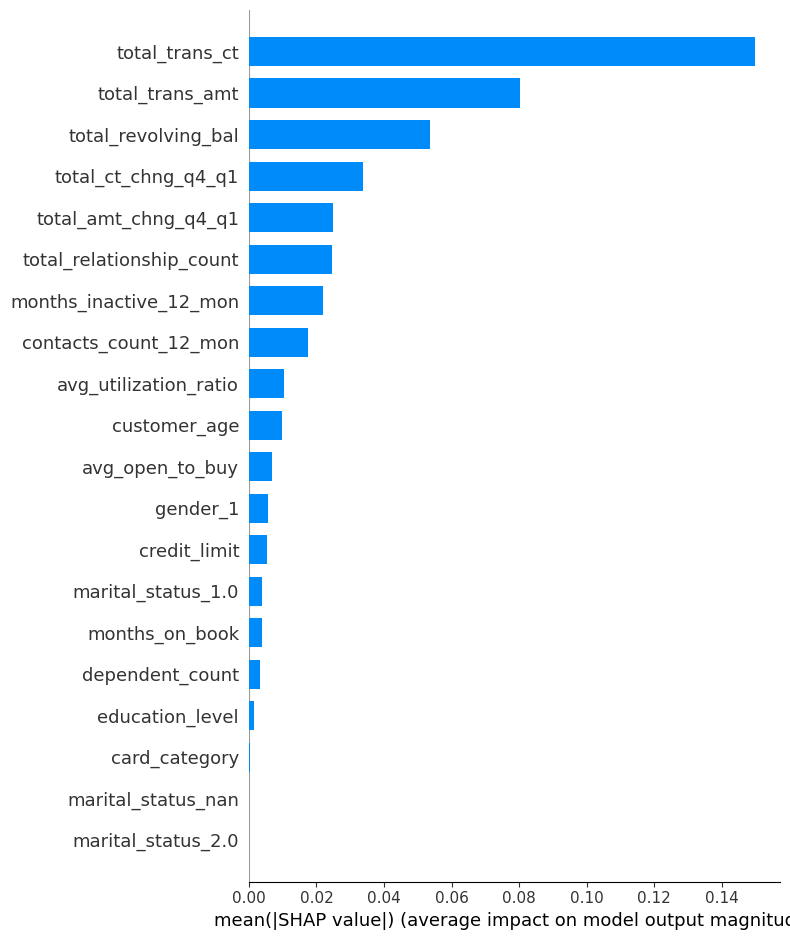

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

## Beeswarm plot

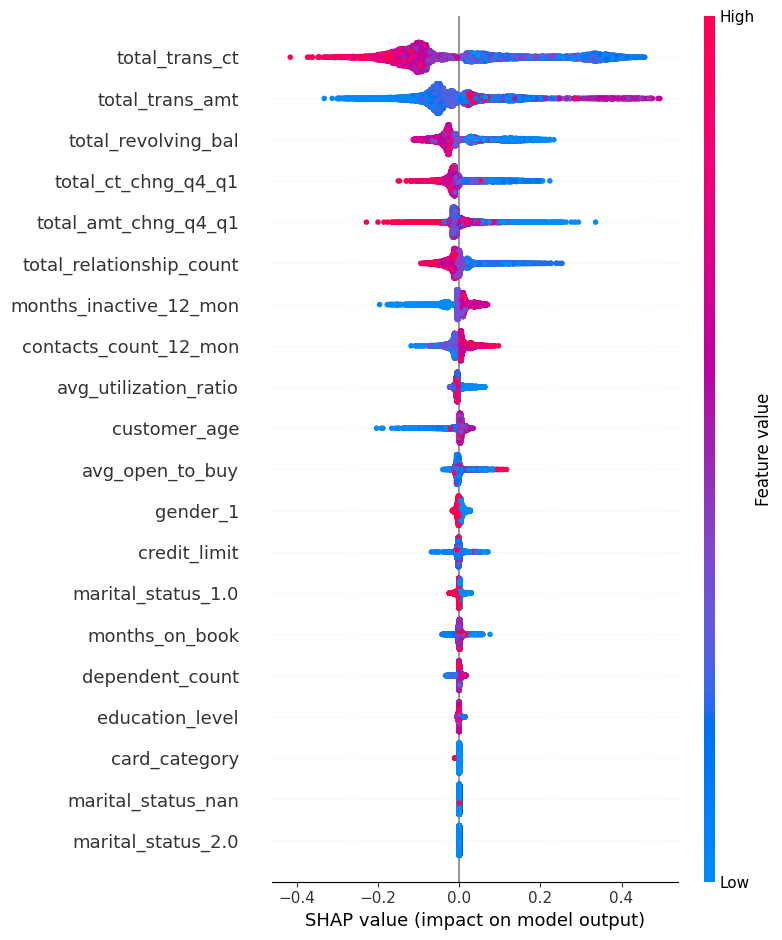

In [ ]:
shap.summary_plot(shap_values, X_train)

## Partial dependence plot

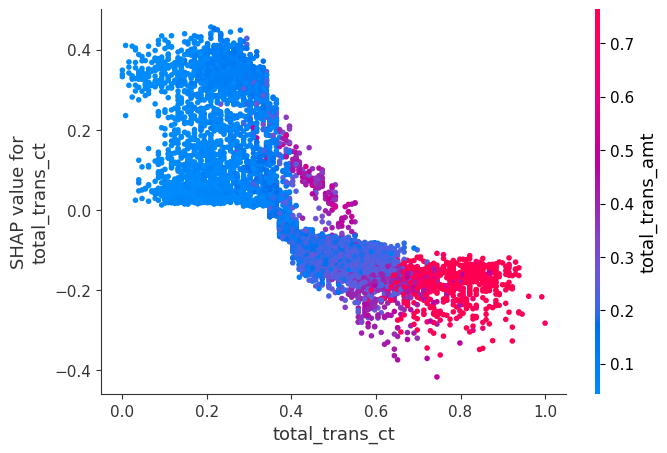

In [ ]:
shap.dependence_plot(
  'total_trans_ct',
  shap_values,
  X_train,
)

## Waterfall

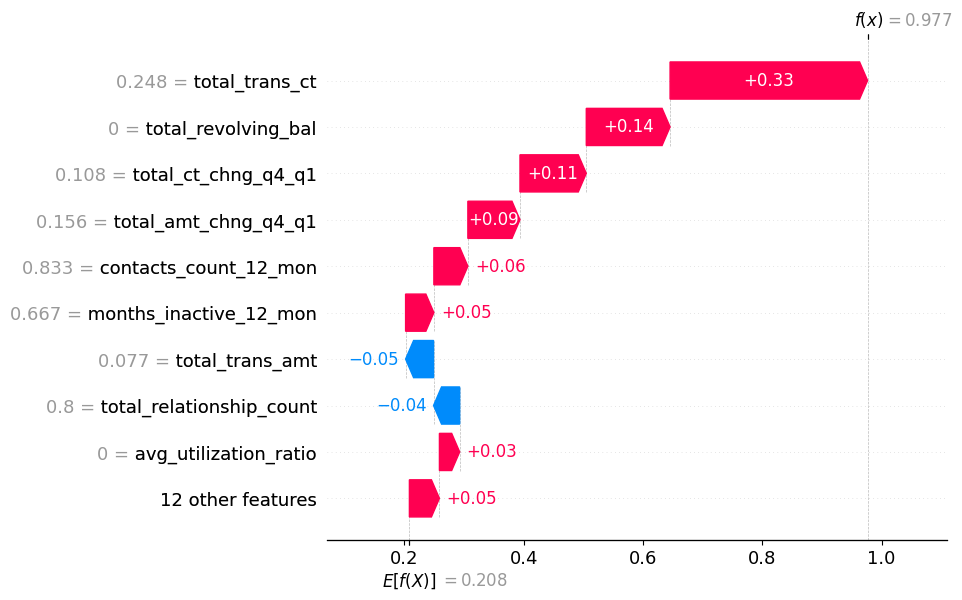

In [ ]:
shap.plots.waterfall(explanation[11])

# Insight dan Rekomendasi Bisnis

## Insight dari Analisis & Model
- Pelanggan dengan **aktivitas transaksi rendah**, **penurunan frekuensi transaksi antar kuartal**, serta **penggunaan kredit rendah (low utilization ratio)** memiliki probabilitas churn yang tinggi.
- Fitur seperti `total_trans_ct`, `total_ct_chng_q4_q1`, dan `avg_utilization_ratio` menjadi penentu utama dalam prediksi churn berdasarkan hasil SHAP.
- **Usia tidak memiliki hubungan signifikan**, namun kelompok usia 50+ menunjukkan kecenderungan churn sedikit lebih tinggi.
- **Durasi menjadi nasabah (months_on_book)** tidak menjamin loyalitas — pelanggan lama pun tetap bisa churn.

## Rekomendasi
1. **Segmentasi Nasabah Berisiko Tinggi**  
   Fokuskan retensi pada pelanggan dengan:
   - Penurunan aktivitas transaksi (`total_ct_chng_q4_q1` < 0.5)
   - Transaksi tahunan rendah (`total_trans_ct` < 50)
   - Utilisasi rendah (`avg_utilization_ratio` < 0.1)

2. **Program Loyalitas dan Aktivasi**  
   Berikan insentif atau promosi khusus untuk:
   - Meningkatkan frekuensi penggunaan kartu
   - Mendorong repeat transaction dari nasabah dengan pola transaksi menurun

3. **Monitoring & Notifikasi Dini**  
   Buat sistem alert untuk mengenali nasabah dengan tanda-tanda potensi churn berdasarkan fitur penting (misal penurunan transaksi signifikan dalam 3 bulan terakhir).

4. **Evaluasi Interaksi Layanan**  
   Pelanggan dengan interaksi minim terhadap bank (`contacts_count_12_mon`) juga bisa menjadi target pendekatan personalisasi.